[View in Colaboratory](https://colab.research.google.com/github/shivamgoel1791/Art_generation-NST-/blob/master/Art_generation_tensorflow.ipynb)

In [1]:
from __future__ import print_function
import numpy as np
from PIL import Image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras import backend
from keras.models import Model
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [30]:
from google.colab import files
uploaded = files.upload()

Saving img1.jpg to img1.jpg


In [4]:
!ls

content_image_0.JPG  datalab  style_image_29.jpg


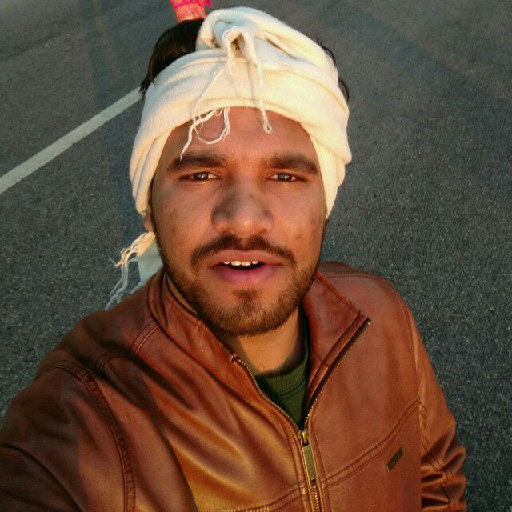

In [32]:
content_image=Image.open('img1.jpg')
content_image=content_image.resize((512,512))

content_image

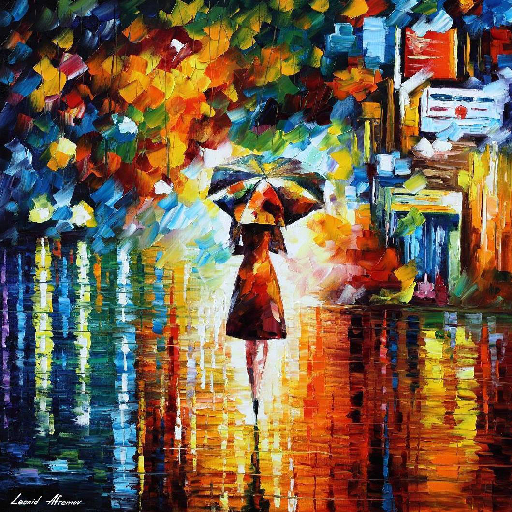

In [33]:
style_image= Image.open('style_image_29.jpg')
style_image=style_image.resize((512,512))

style_image

In [34]:
content_array=np.asarray(content_image,dtype='float32')
#print (content_array.shape)
content_array=np.expand_dims(content_array,axis=0)
content_array = content_array[:,:,:,:3]

style_array=np.asarray(style_image,dtype='float32')
#print (style_array.shape)
style_array=np.expand_dims(style_array,axis=0)
style_array = style_array[:,:,:,:3]

print(content_array.shape)
print(style_array.shape)
#style_array[0,0,0,:]

(1, 512, 512, 3)
(1, 512, 512, 3)


In [35]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array=content_array[:, :, :, ::-1]


style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array=style_array[:, :, :, ::-1]
print (content_array.shape,style_array.shape, style_array[0,0,0,:])

(1, 512, 512, 3) (1, 512, 512, 3) [-106.68  -104.779  -89.939]


In [36]:
height=512
width=512
content_image=backend.variable(content_array)
style_image=backend.variable(style_array)
combination_image=backend.placeholder((1,height,width,3), dtype = 'float32')

print (content_image, style_image, combination_image)

input_tensor=backend.concatenate([content_image,style_image,combination_image],axis=0)
input_tensor

<tf.Variable 'Variable_3:0' shape=(1, 512, 512, 3) dtype=float32_ref> <tf.Variable 'Variable_4:0' shape=(1, 512, 512, 3) dtype=float32_ref> Tensor("Placeholder_27:0", shape=(1, 512, 512, 3), dtype=float32)


<tf.Tensor 'concat_1:0' shape=(3, 512, 512, 3) dtype=float32>

In [0]:
model1=VGG16(input_tensor=input_tensor,weights='imagenet', include_top=False)
#model2=ResNet50(input_tensor=input_tensor,weights='imagenet', include_top=False)
#model3=InceptionV3(input_tensor=input_tensor,weights='imagenet', include_top=False)

In [38]:
layers=dict([(layer.name, layer.output) for layer in model1.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1_1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_1/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_1/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_1/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1_1/Relu:0' shape=(3, 64, 64, 51

In [0]:
content_weight = 0.05
style_weight = 5.0
total_variation_weight = 1.0

In [0]:
loss=backend.variable(0.)

In [0]:
feature_layers_1 = ['block2_conv2']

In [0]:
def content_loss(content, combination):
    return backend.sum(backend.square(content-combination))

In [0]:
for layer_name in feature_layers_1:
    layer_features=layers[layer_name]
    content_image_features=layer_features[0,:,:,:]
    combination_features=layer_features[2,:,:,:]
    loss+=content_weight*content_loss(content_image_features,combination_features)

In [0]:
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

In [0]:
def gram_matrix(x):
    features=backend.batch_flatten(backend.permute_dimensions(x,(2,0,1)))
    gram=backend.dot(features, backend.transpose(features))
    return gram

  
def style_loss(style,combination):
    S=gram_matrix(style)
    C=gram_matrix(combination)
    channels=3
    size=height * width
    st=backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
    return st

In [0]:
for layer_name in feature_layers:
    layer_features=layers[layer_name]
    style_features=layer_features[1,:,:,:]
    combination_features=layer_features[2,:,:,:]
    sl=style_loss(style_features,combination_features)
    loss+=(style_weight/len(feature_layers))*sl

In [0]:
def total_variation_loss(x):
    a=backend.square(x[:,:height-1,:width-1,:]-x[:,1:,:width-1,:])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))
loss += total_variation_weight * total_variation_loss(combination_image)

In [0]:
grads = backend.gradients(loss, combination_image)

In [0]:
outputs=[loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = backend.function([combination_image], outputs)

In [0]:
def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

In [0]:
class Evaluator(object):
    def __init__(self):
        self.loss_value=None
        self.grads_values=None
    
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

      
evaluator=Evaluator()

In [0]:
x=np.random.uniform(0,255,(1,height,width,3))-128.0

In [0]:
iterations = 10

In [54]:
import time
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),fprime=evaluator.grads, maxfun=20)
    print(min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
231225280000.0
Iteration 0 completed in 19s
Start of iteration 1
155385400000.0
Iteration 1 completed in 17s
Start of iteration 2
123096105000.0
Iteration 2 completed in 17s
Start of iteration 3
111698715000.0
Iteration 3 completed in 17s
Start of iteration 4
104994320000.0
Iteration 4 completed in 17s
Start of iteration 5
101555530000.0
Iteration 5 completed in 17s
Start of iteration 6
98727944000.0
Iteration 6 completed in 17s
Start of iteration 7
97109690000.0
Iteration 7 completed in 17s
Start of iteration 8
95980765000.0
Iteration 8 completed in 17s
Start of iteration 9
95106520000.0
Iteration 9 completed in 17s


In [0]:
print
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

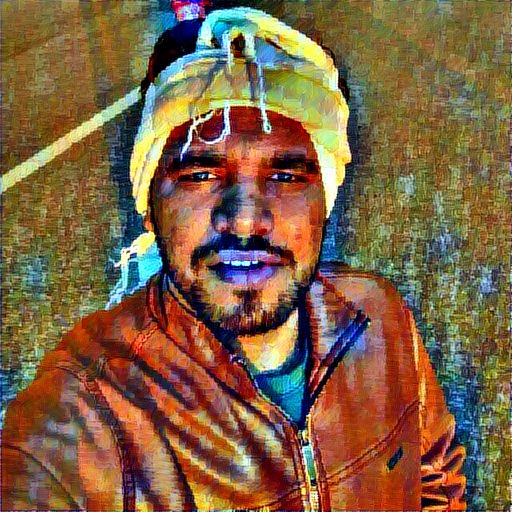

In [56]:
Image.fromarray(x)